In [1]:
%matplotlib notebook
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.signal import spectrogram, stft, istft, check_NOLA
import pickle

# IMPORT DATA AND PREPROCESS

In [2]:
subsampleFreq = 64   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING

# 31, 35, 38 and test folders for good data
# odd scalp on left, even on right

# SPECIFY PATIENT AND SCALP TARGET ELECTRODE
patient = 'UFSEEG031'
targetScalpElectrode = 'F7'

# SPECIFY ARTIFACT ELECTRODES FROM WORD FILES
artifactElectrodes = {}
artifactElectrodes['UFSEEG031'] = ['LTP7', 'LTP8', 'LAH11', 'LAH12', 'LPH10', 'LPH11', 'LPH12','LOF15', 'LOF16']

#filepath = '//ahcdfs.ahc.ufl.edu/files/NLGY/Groups/Epilepsy/KalamangalamLab/SEEG/%s/SEEG/EDF/TestClipSleep/TestClipSleep.edf' % patient
#filepath = 'C:/Users/the_m/Data/uFlorida/predictScalp/TestClipSleep.edf'
filepath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/TestClipSleep.edf'

raw = mne.io.read_raw_edf(filepath,preload=True)
sfreq = int(raw.info['sfreq'])

scalpElectrodes = {}
scalpElectrodes[patient] = [i for i in raw.ch_names if len(i) == 2]
print()
print(scalpElectrodes)
print(raw)
print(raw.info)

Extracting EDF parameters from /blue/gkalamangalam/jmark.ettinger/predictScalp/TestClipSleep.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1766015  =      0.000 ...  1724.624 secs...

{'UFSEEG031': ['F7', 'F8', 'F3', 'F4', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4', 'PR']}
<RawEDF | TestClipSleep.edf, 148 x 1766016 (1724.6 s), ~1.95 GB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: LTP1, LTP2, LTP3, LTP4, LTP5, LTP6, LTP7, LTP8, LAM1, LAM2, ...
 chs: 148 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2001-01-01 02:05:22 UTC
 nchan: 148
 projs: []
 sfreq: 1024.0 Hz
>


<IPython.core.display.Javascript object>


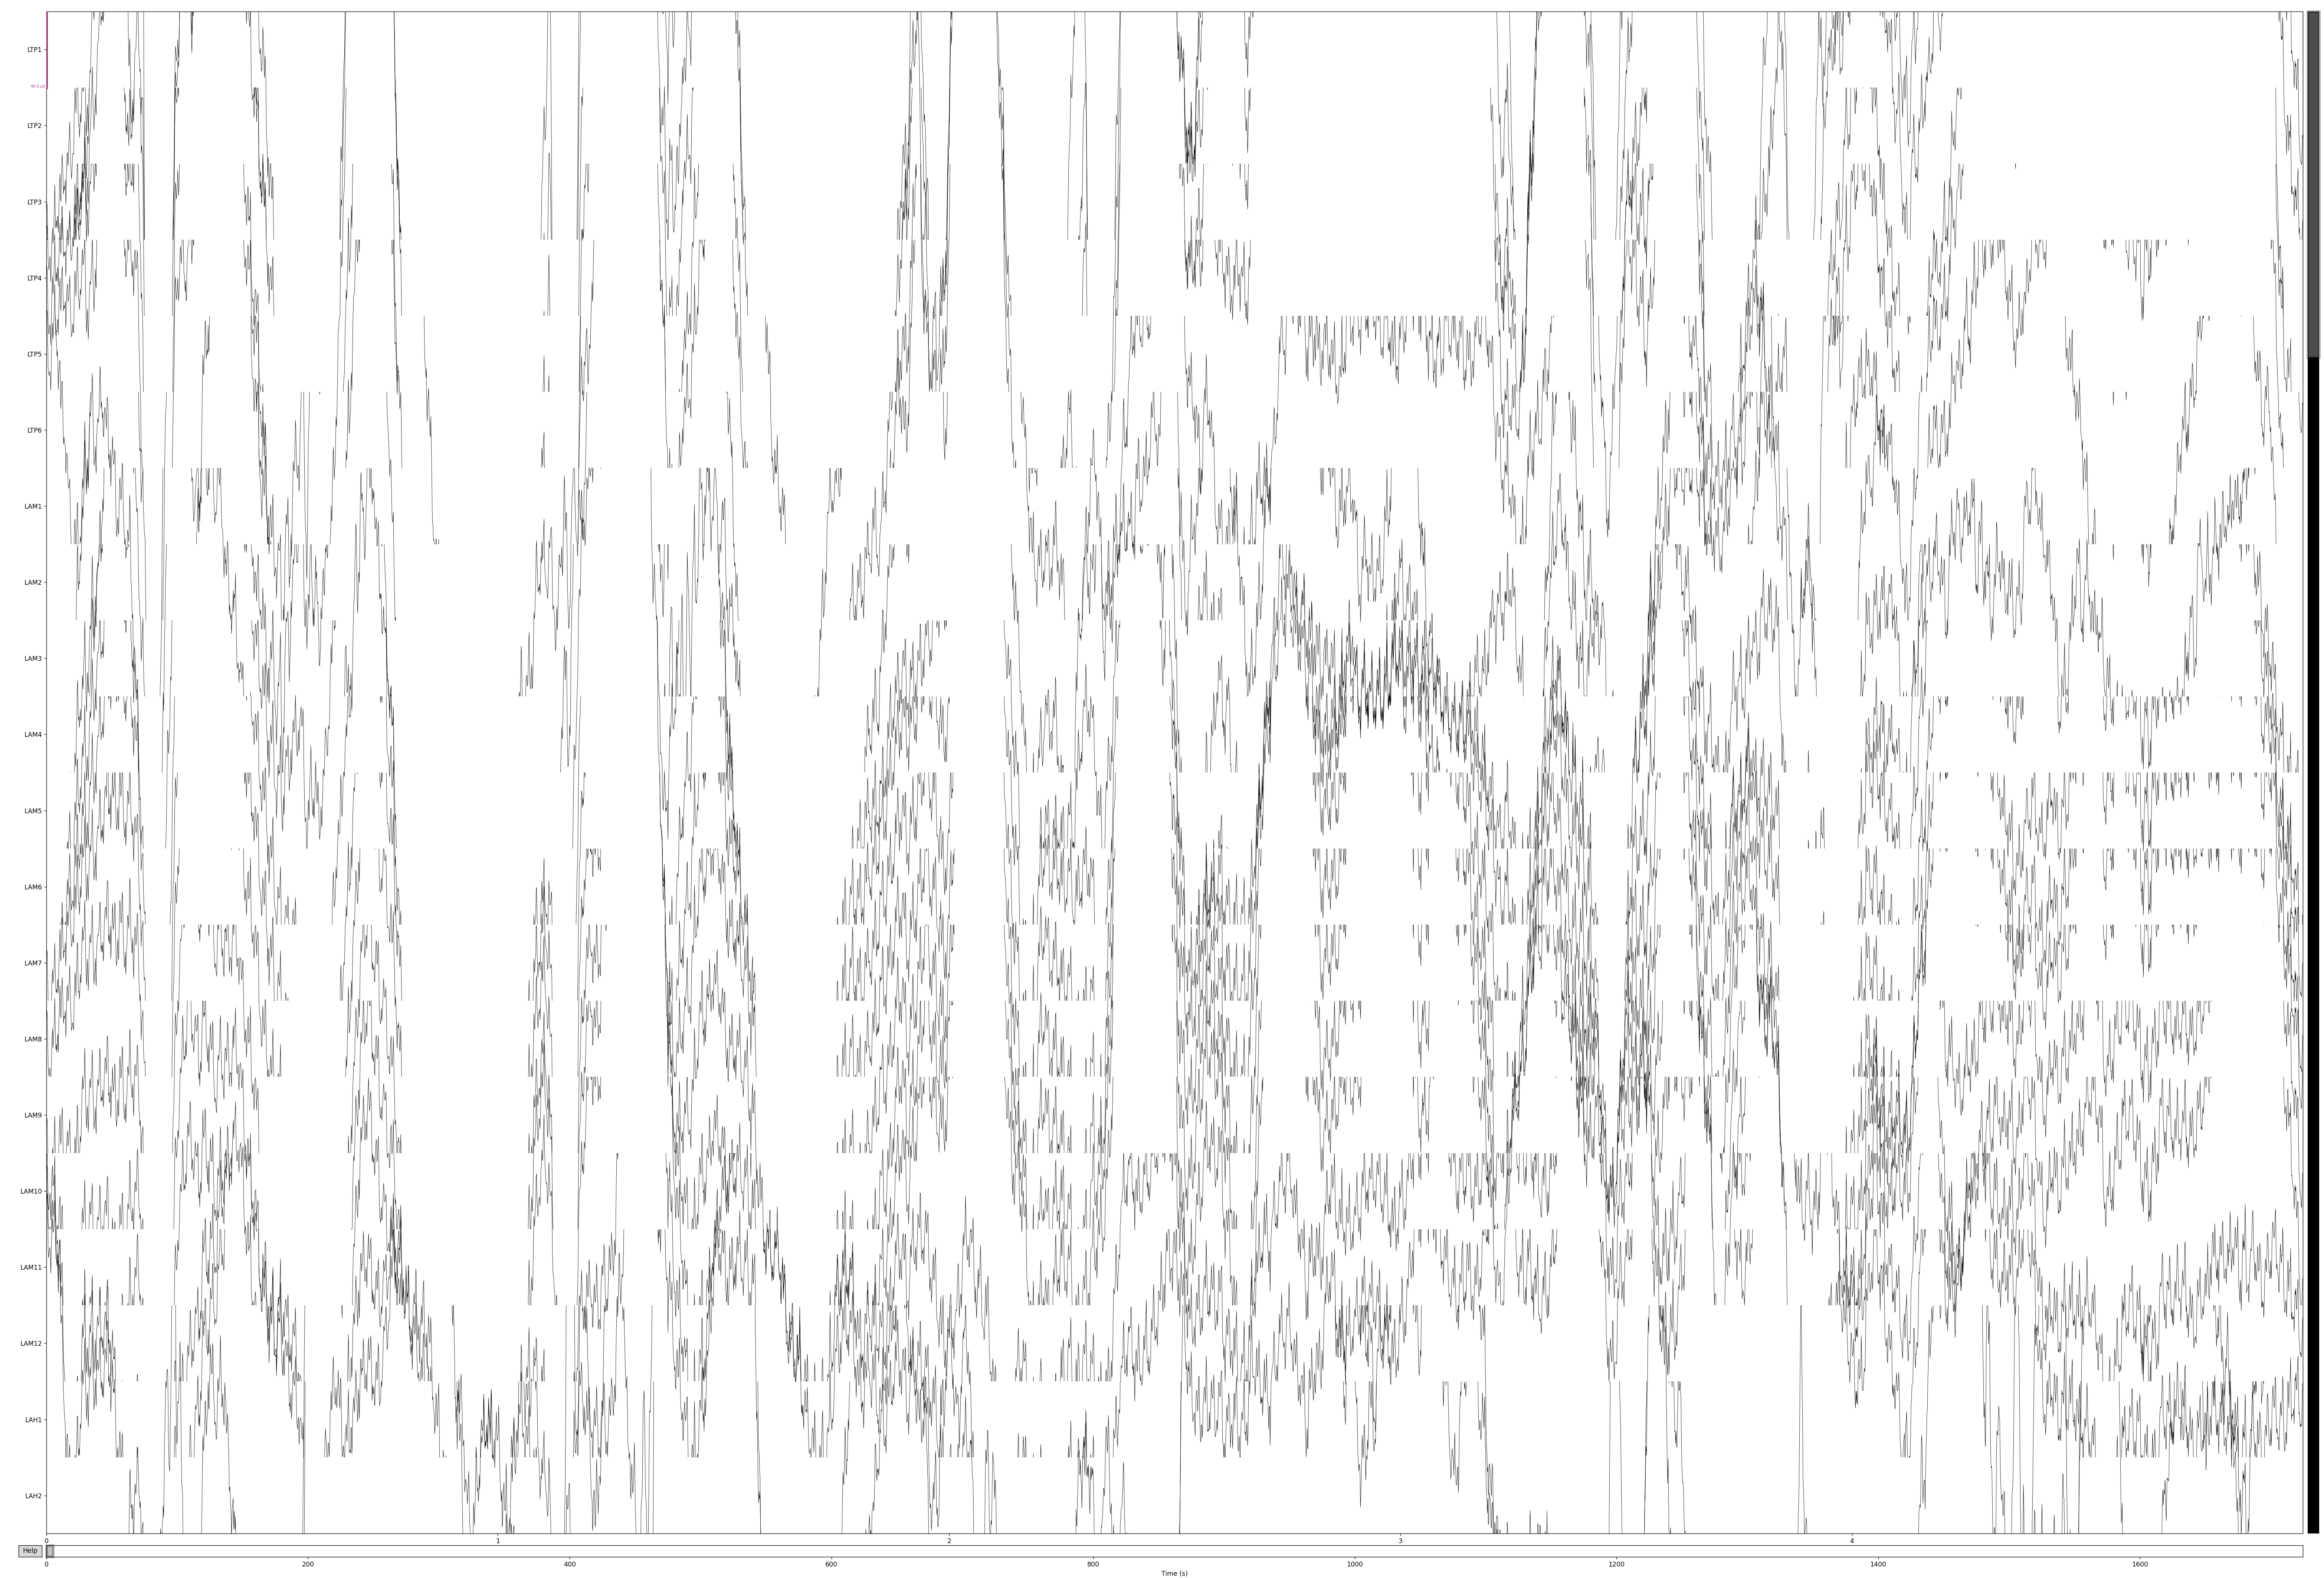

In [3]:
# DISCARD ALL CHANNELS EXCEPT GOOD SEEG CHANNELS AND THE SINGLE SCALP TARGET

channels = [i for i in raw.ch_names if i not in artifactElectrodes[patient] and i[0] in {'L', 'R'}] + [targetScalpElectrode]
raw.pick_channels(channels).plot(duration=5.0, n_channels=20);

In [10]:
# SUBSAMPLE THE DATA, MAKE MEAN=0 FOR ALL CHANNELS, AND EXTRACT TO NUMPY ARRAY

df = raw.to_data_frame().drop(labels=['time'], axis=1)
data = df.to_numpy()
dataSubsampled = data[::sfreq // subsampleFreq,:]

scaler = StandardScaler()
dataSubsampled = scaler.fit_transform(dataSubsampled)

pd.DataFrame(dataSubsampled, columns=df.columns)

LTP1      LTP2      LTP3      LTP4      LTP5      LTP6      LAM1  \
0      -0.667629 -0.549871 -0.330717 -0.630646 -0.410280  0.428081 -1.039227   
1      -0.712668 -0.584065 -0.361013 -0.630646 -0.411507  0.366330 -1.257588   
2      -0.820934 -0.553894 -0.281617 -0.557776 -0.351390  0.041465 -1.109620   
3      -0.734321 -0.509644 -0.187594 -0.518387 -0.301087 -0.119625 -0.800754   
4      -0.652038 -0.460365 -0.076856 -0.448471 -0.292499 -0.295481 -0.422933   
...          ...       ...       ...       ...       ...       ...       ...   
110371 -1.356203 -2.084557 -2.941412 -2.358846 -2.887359 -1.663403 -0.322372   
110372 -0.189525 -0.732907 -1.561369 -1.391842 -2.113195 -0.274003 -0.404257   
110373  0.360468  0.474929 -0.219979 -0.254479 -1.017588  0.885845 -0.221811   
110374  0.806525  1.029065  0.579213  0.381656 -0.351390  1.186546 -0.004887   
110375  0.007953  0.013316  0.007764  0.014352 -0.004181  0.003878 -0.002014   

            LAM2      LAM3      LAM4  ...      LOF6      LOF7      LOF8  \
0      -1.477728 -1.064401 -0.821826  ... -0.472943 -0.251527 -0.305150   
1      -1.581453 -1.212919 -0.933384  ... -0.527897 -0.330268 -0.316427   
2      -1.505221 -1.168054 -0.842252  ... -0.652657 -0.447420 -0.390357   
3      -1.212791 -0.782834 -0.584569  ... -0.566513 -0.345632 -0.326452   
4      -1.069076 -0.720952 -0.491866  ... -0.602158 -0.478148 -0.352766   
...          ...       ...       ...  ...       ...       ...       ...   
110371  0.745489  0.437801 -1.374902  ... -0.597703  0.142180  1.016814   
110372  0.254357  0.426972 -0.977378  ... -0.903662 -0.240004  0.818833   
110373  0.011915  0.754950 -0.416446  ... -0.804151 -0.176627  0.802543   
110374  0.004417  1.016404 -0.089629  ... -0.578395  0.011585  0.805049   
110375  0.001917  0.015452  0.001503  ...  0.006789 -0.009541  0.058233   

            LOF9     LOF10     LOF11     LOF12     LOF13     LOF14        F7  
0      -0.427908 -0.342807 -0.520762 -0.676989 -1.556636 -1.435830  1.480424  
1      -0.410165 -0.289228 -0.484664 -0.645461 -1.618791 -1.488961  1.276494  
2      -0.489201 -0.348165 -0.505292 -0.613933 -1.644856 -1.407051  0.784248  
3      -0.369840 -0.074913 -0.162353 -0.327927 -1.448366 -1.249871  0.981146  
4      -0.397261 -0.131171 -0.208766 -0.264871 -1.500496 -1.072767  0.805344  
...          ...       ...       ...       ...       ...       ...       ...  
110371  0.115666  1.299382  1.505925  1.430897  1.482946  0.678347  1.220237  
110372 -0.094021  0.977910  1.170722  1.192183  1.244351  0.459181  1.339782  
110373 -0.189187  0.626969  0.696281  0.656204  0.961646 -0.038924  1.178044  
110374 -0.311773  0.278707 -0.012801 -0.156774  0.733076 -0.253662  0.650638  
110375 -0.016598 -0.005261  0.002669 -0.008141  0.015285  0.016421  0.017751  

[110376 rows x 88 columns]

In [12]:
# APPLY SHORT TERM FOURIER TRANSFORM TO THE DATA AND CHECK PARAMETERS FOR INVERTABILITY

secondsInWindow = 1.
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

f, t, S = stft(dataSubsampled, fs=subsampleFreq, window=window, nperseg=nperseg, noverlap=noverlap, axis=0)

print('freq, ', 'time, ', 'stft shape')
print(f.shape, t.shape, S.shape)
print('inverse ok? ',check_NOLA(window, nperseg, noverlap))

freq,  time,  stft shape
(33,) (110377,) (33, 88, 110377)
inverse ok?  True


<IPython.core.display.Javascript object>


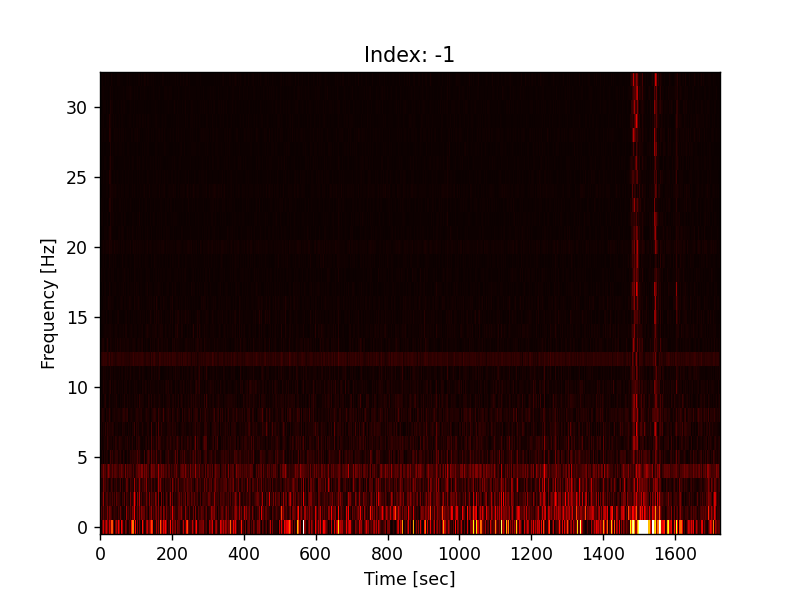

In [14]:
# PLOT THE STFT OF A TIME SERIES (MAGNITUDE ONLY)

index = -1 # -1 is the target
vmax = 2

plt.figure()
plt.pcolormesh(t, f, np.abs(S[:,index,:]), shading='auto', cmap='hot', vmin=0, vmax=vmax)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Index: %s' % str(index))
plt.show()

In [18]:
# PARTITION TIME SERIES INTO CONTIGUOUS TRAIN AND VALIDATION BLOCKS
# OTHERWISE WHEN VALID SET IS RANDOMLY DISTRIBUTED, IMPLICIT OVERFITTING OCCURS DUE TO TEMPORAL DEPENDENCY
# EACH BLOCK (SPECIFIED IN SECONDS) IS DIVIDED INTO TRAIN (SPECIFIED BY FRACTION, COMES FIRST) AND VALIDIDATION (COMES LAST)

def timeseriesTrainValidSplit(secondsInBlock, totalSeconds, trainFraction, subsampleFreq):
    nBlock = int(totalSeconds / secondsInBlock)
    samplesPerBlock = subsampleFreq * secondsInBlock
    trainIndexProto = np.arange(0, samplesPerBlock * trainFraction, dtype=int)
    validIndexProto = np.arange(samplesPerBlock * trainFraction, samplesPerBlock, dtype=int)

    trainIndexBlocks = [(trainIndexProto + (i * samplesPerBlock)).astype(int) for i in range(nBlock)]
    validIndexBlocks = [(validIndexProto + (i * samplesPerBlock)).astype(int) for i in range(nBlock)]

    trainIndices = np.concatenate(trainIndexBlocks).astype(int)
    validationIndices = np.concatenate(validIndexBlocks).astype(int)
    return trainIndices, validationIndices

# TIME DOMAIN DATA

In [23]:
secondsInBlock = 1
totalSeconds = 1720
trainFraction = .8

trainIndices, validationIndices = timeseriesTrainValidSplit(secondsInBlock, totalSeconds, trainFraction, subsampleFreq)

xTrainTimeDomain = dataSubsampled[trainIndices, 0:-1]
yTrainTimeDomain = dataSubsampled[trainIndices, -1]

xValidTimeDomain = dataSubsampled[validationIndices, 0:-1]
yValidTimeDomain = dataSubsampled[validationIndices, -1]

xTrainTimeDomain.shape, yTrainTimeDomain.shape, xValidTimeDomain.shape, yValidTimeDomain.shape

((89440, 87), (89440,), (22360, 87), (22360,))

In [22]:
arraySavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/trainTestTimeDomain.npz'
np.savez(arraySavePath, 
         xTrainTimeDomain=xTrainTimeDomain, 
         xValidTimeDomain=xValidTimeDomain,
         yTrainTimeDomain=yTrainTimeDomain,
         yValidTimeDomain=yValidTimeDomain)

# STFT DATA

In [19]:
secondsInBlock = 1
totalSeconds = 1720
trainFraction = .8

trainIndices, validationIndices = timeseriesTrainValidSplit(secondsInBlock, totalSeconds, trainFraction, subsampleFreq)

x_trainComplex = S[:, 0:-1, trainIndices].transpose([2,0,1])
y_trainComplex = S[:, -1, trainIndices].transpose()

x_validComplex = S[:, 0:-1, validationIndices].transpose([2,0,1])
y_validComplex = S[:, -1, validationIndices].transpose()

# MAKE REAL-VALUED TRAINING DATA BY CONVERTING STFT COMPLEX NUMBERS TO R,THETA
_,_,numCol = x_trainComplex.shape
x_trainRTheta = np.hstack([np.hstack([np.abs(x_trainComplex[:,:,i]), 
                                      np.angle(x_trainComplex[:,:,i])]) for i in range(numCol)])
x_validRTheta = np.hstack([np.hstack([np.abs(x_validComplex[:,:,i]), 
                                      np.angle(x_validComplex[:,:,i])]) for i in range(numCol)])

y_trainRTheta = np.hstack([np.abs(y_trainComplex), np.angle(y_trainComplex)])
y_validRTheta = np.hstack([np.abs(y_validComplex), np.angle(y_validComplex)])

_, nY = y_trainRTheta.shape
x_trainRTheta.shape, x_validRTheta.shape, y_trainRTheta.shape, y_validRTheta.shape

((89440, 5742), (22360, 5742), (89440, 66), (22360, 66))

In [ ]:
arraySavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/trainTestRTheta.npz'
np.savez(arraySavePath, 
         x_trainRTheta=x_trainRTheta, 
         x_validRTheta=x_validRTheta, 
         y_trainRTheta=y_trainRTheta, 
         y_validRTheta=y_validRTheta)